## Analyze IMU Errors on the dataset

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import json

# Get environment variables
import sys
sys.path.append("..")  # Add the parent directory of notebooks to sys.path

from lac.plotting import pose_traces

%load_ext autoreload
%autoreload 2

In [2]:
data_files = ["data_collection_1", "data_collection_2", "start_stop", "turn_in_place"]

idx = 3
data_path = "../../outputs/" + data_files[idx]
json_data = json.load(open(f"{data_path}/data_log.json"))
print(json_data.keys())

dict_keys(['initial_pose', 'lander_pose', 'frames'])


In [3]:
from lac.util import *

G_MOON = 1.62519  # m/s^2

frames = json_data["frames"]
nframes = len(frames)

true_time = np.zeros(nframes)
true_pva = np.zeros((nframes, 9))  # pos, vel, acc
true_att = np.zeros((nframes, 6))  # rpy, rpy_dot
imu_acc = np.zeros((nframes, 3))
imu_gyro = np.zeros((nframes, 3))
imu_acc_raw = np.zeros((nframes, 3))

rpy_prev = np.zeros(3)

for i, frame in enumerate(frames):
    timestamp = frame["timestamp"]
    pose = np.array(frame["pose"])
    imu_dat = np.array(frame["imu"])

    rpy, pos = pose_to_rpy_pos(pose)
    acc, gyro = imu_dat[:3], imu_dat[3:]

    imu_acc_raw[i] = acc

    for j in range(3):
        if rpy[j] - rpy_prev[j] > np.pi:
            rpy[j] -= 2*np.pi
        elif rpy[j] - rpy_prev[j] < -np.pi:
            rpy[j] += 2*np.pi

    rpy_prev = rpy

    # convert acc to inertial frame
    R_b2i = pose[:3, :3]  # using the true pose
    acc = R_b2i @ acc
    
    # remove gravity
    acc[2] -= G_MOON

    true_time[i] = timestamp
    true_pva[i, :3] = pos
    true_att[i, :3] = rpy

    imu_acc[i] = acc
    imu_gyro[i] = gyro

# Get true velocity and acceleration data
true_pva[0, 3:] = np.zeros(6)
true_att[0, 3:] = np.zeros(3)
for i in range(1, nframes):
    dt = true_time[i] - true_time[i-1]
    true_pva[i, 3:6] = (true_pva[i, :3] - true_pva[i-1, :3]) / dt
    diff_att = true_att[i, :3] - true_att[i-1, :3]
    for j in range(3):
        if diff_att[j] > np.pi:
            diff_att[j] -= 2*np.pi
        elif diff_att[j] < -np.pi:
            diff_att[j] += 2*np.pi
    true_att[i, 3:] = diff_att / dt

true_pva[0, 6:] = np.zeros(3)
for i in range(1, nframes-1):
    dt = true_time[i+1] - true_time[i-1]
    true_pva[i, 6:] = (true_pva[i+1, 3:6] - true_pva[i-1, 3:6]) / 2/dt



## Plot the IMU Data

Mean acc residuals: [-0.00105013  0.00279083 -0.00129463]
Std acc residuals: [0.15309575 0.12699971 0.23342927]
Mean gyro residuals: [-0.00092737  0.00308213 -0.00576235]
Std gyro residuals: [0.08379224 0.07642084 0.05879302]


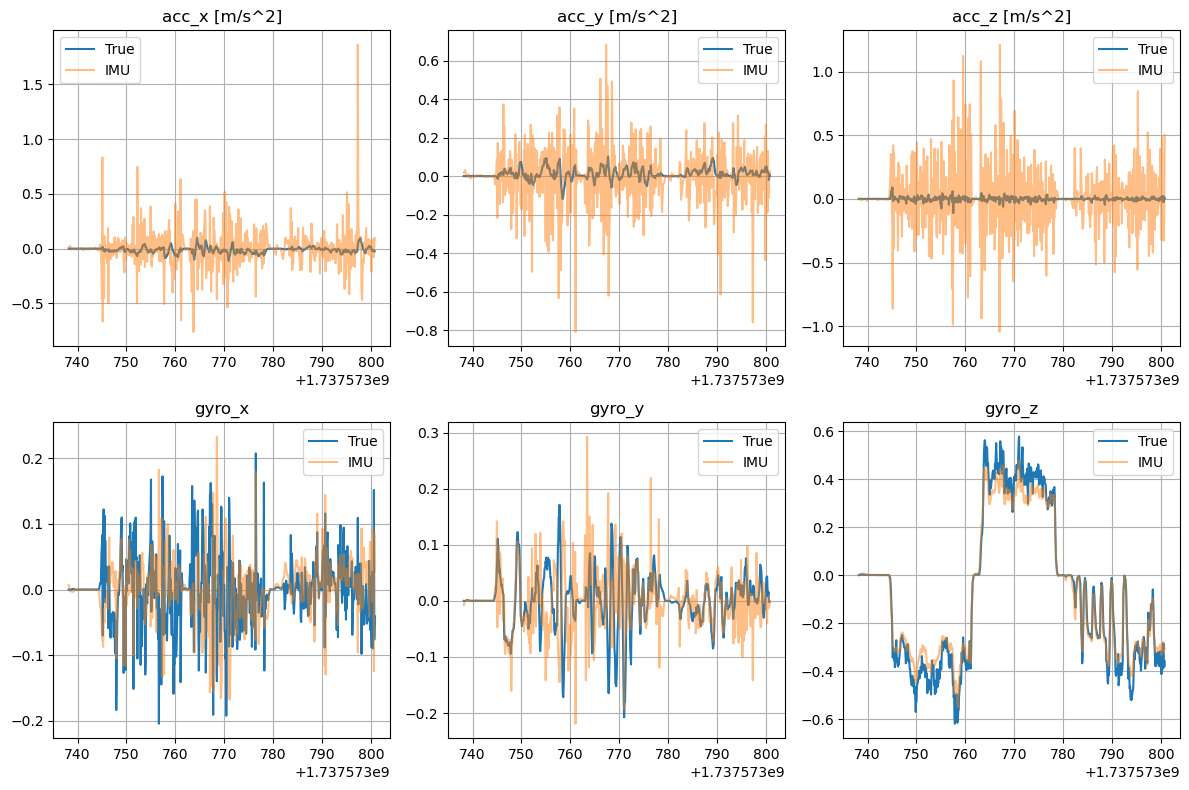

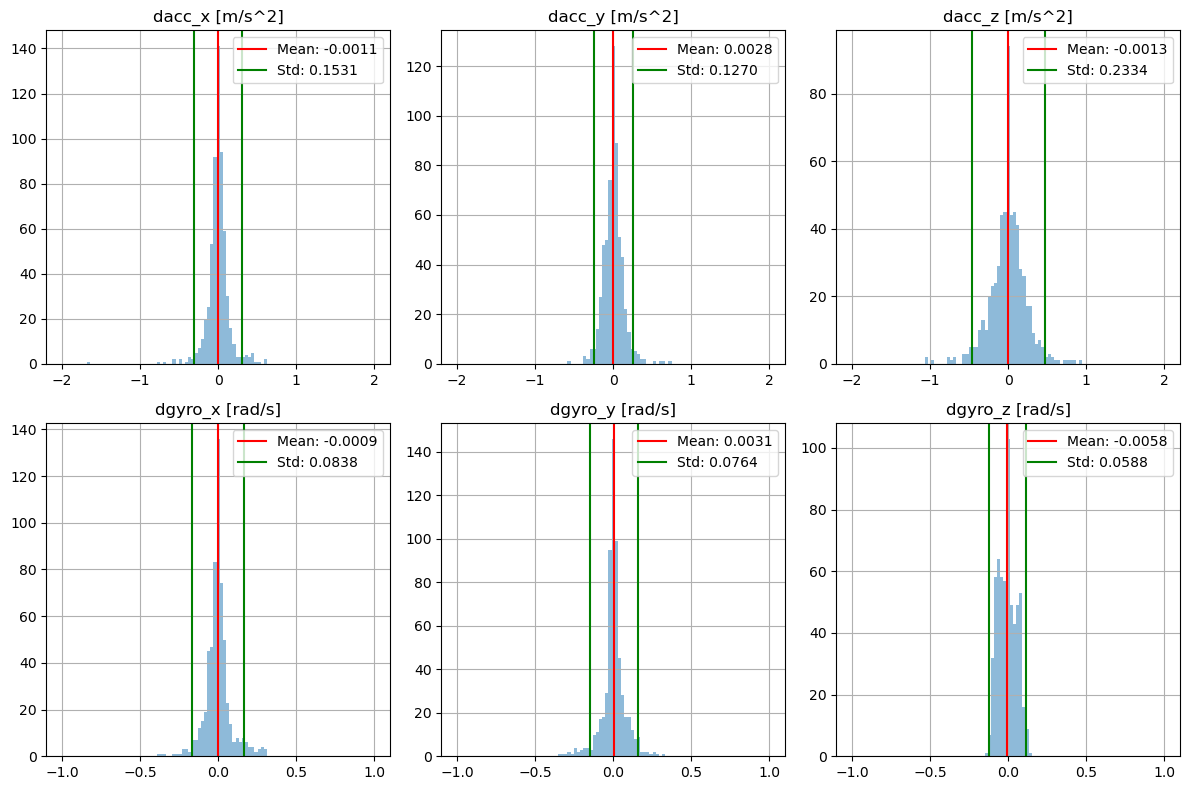

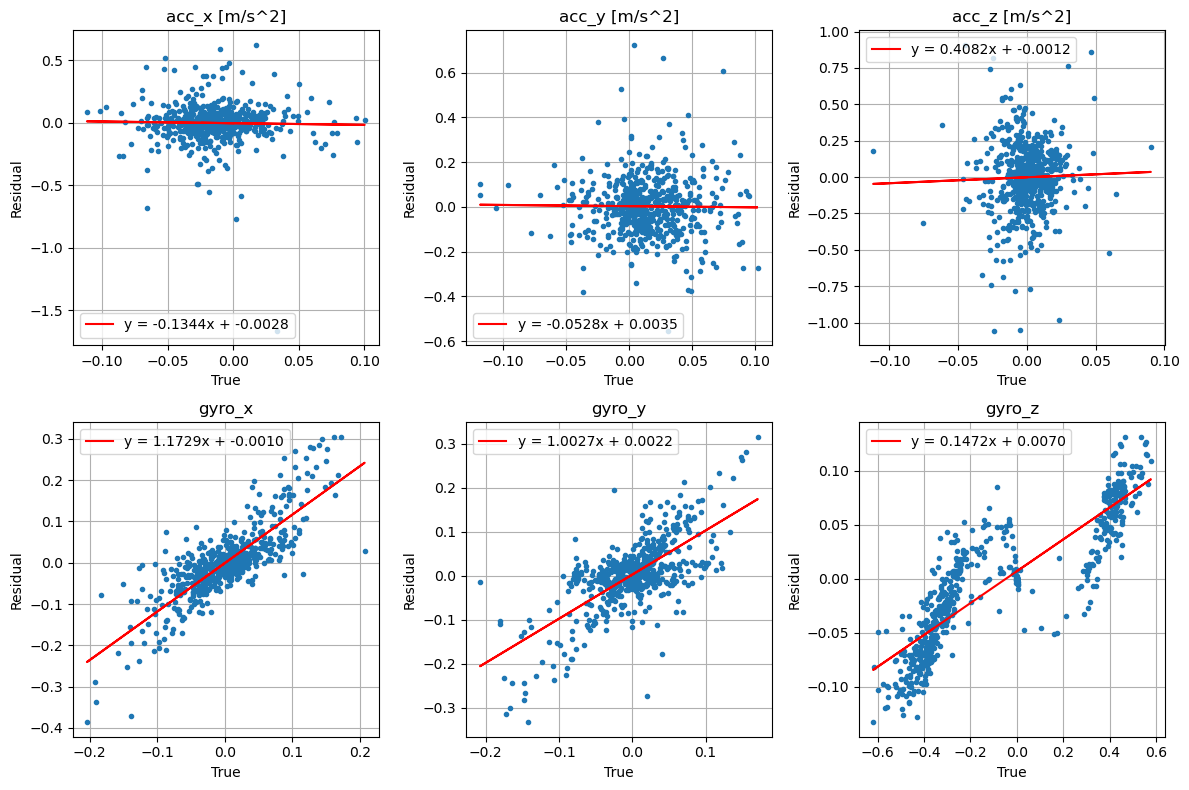

In [4]:
import matplotlib.pyplot as plt

# Get the residuals
res_acc = true_pva[:, 6:] - imu_acc
res_gyro = true_att[:, 3:] - imu_gyro

mean_acc = np.mean(res_acc, axis=0)
std_acc = np.std(res_acc, axis=0)

mean_gyro = np.mean(res_gyro, axis=0)
std_gyro = np.std(res_gyro, axis=0)

print("Mean acc residuals:", mean_acc)
print("Std acc residuals:", std_acc)
print("Mean gyro residuals:", mean_gyro)
print("Std gyro residuals:", std_gyro)

# plot true vs measured
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
pos_labels = ["acc_x [m/s^2]", "acc_y [m/s^2]", "acc_z [m/s^2]", "gyro_x", "gyro_y", "gyro_z"]
for i in range(6):
    ax = axes.flatten()[i]  
    smooth_window = 5
    # smooth imu data
    if i < 3:
        ax.plot(true_time, true_pva[:, i+3], label="True")
        ax.plot(true_time, imu_acc[:, i], label="IMU", alpha=0.5)
        imu_acc_smooth = np.convolve(imu_acc[:, i], np.ones(smooth_window)/smooth_window, mode='same')
        # ax.plot(true_time, imu_acc_smooth, label="IMU Smooth", alpha=0.5)
    else:
        ax.plot(true_time, true_att[:, i], label="True")
        ax.plot(true_time, imu_gyro[:, i-3], label="IMU", alpha=0.5)
        imu_gyro_smooth = np.convolve(imu_gyro[:, i-3], np.ones(smooth_window)/smooth_window, mode='same')
        # ax.plot(true_time, imu_gyro_smooth, label="IMU Smooth", alpha=0.5)
    ax.set_title(pos_labels[i])
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

# plot residuals
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
pos_labels = ["dacc_x [m/s^2]", "dacc_y [m/s^2]", "dacc_z [m/s^2]", "dgyro_x [rad/s]", "dgyro_y [rad/s]", "dgyro_z [rad/s]"]
for i in range(6):
    ax = axes.flatten()[i]  
    if i < 3:
        # plot histogram
        bins = np.linspace(-2, 2, 100)
        ax.hist(res_acc[:, i], bins, alpha=0.5)
        ax.axvline(mean_acc[i], color='r', label=f"Mean: {mean_acc[i]:.4f}")
        ax.axvline(mean_acc[i] + 2 * std_acc[i], color='g', label=f"Std: {std_acc[i]:.4f}")
        ax.axvline(mean_acc[i] - 2 * std_acc[i], color='g')
    else:
        # plot histogram
        bins = np.linspace(-1, 1, 100)
        ax.hist(res_gyro[:, i-3], bins, alpha=0.5)
        ax.axvline(mean_gyro[i-3], color='r', label=f"Mean: {mean_gyro[i-3]:.4f}")
        ax.axvline(mean_gyro[i-3] + 2 * std_gyro[i-3], color='g', label=f"Std: {std_gyro[i-3]:.4f}")
        ax.axvline(mean_gyro[i-3] - 2 * std_gyro[i-3], color='g')
    ax.set_title(pos_labels[i])
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

# plot true (x) vs residual (y)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
pos_labels = ["acc_x [m/s^2]", "acc_y [m/s^2]", "acc_z [m/s^2]", "gyro_x", "gyro_y", "gyro_z"]
for i in range(6):
    ax = axes.flatten()[i]  
    if i < 3:
        ax.plot(true_pva[:, i+3], res_acc[:, i], '.')
        # fit a line
        x = true_pva[:, i+3]
        y = res_acc[:, i]
        A = np.vstack([x, np.ones_like(x)]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        ax.plot(x, m*x + c, 'r', label=f"y = {m:.4f}x + {c:.4f}")
    else:
        ax.plot(true_att[:, i], res_gyro[:, i-3], '.')
        # fit a line
        x = true_att[:, i]
        y = res_gyro[:, i-3]
        A = np.vstack([x, np.ones_like(x)]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        ax.plot(x, m*x + c, 'r', label=f"y = {m:.4f}x + {c:.4f}")

    ax.set_xlabel("True")
    ax.set_ylabel("Residual")
    ax.set_title(pos_labels[i])
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


## Compute the Estimated Trajectory

In [8]:
# Get estimated pose from IMU data
est_posvel = np.zeros((nframes, 6))
est_att = np.zeros((nframes, 6))

est_posvel[0, :6] = true_pva[0, :6]
est_att[0, :6] = true_att[0, :6]

imu_acc_meass = np.zeros((nframes, 3))
imu_acc_meas_sm = np.zeros(3)

alpha_acc = 1
alpha_gyro = 1

EPS = 0.001
stop_count = 0


gyro_meas = np.zeros(3)

for i in range(1, nframes):
    dt = true_time[i] - true_time[i-1]

    # smooth imu gyro
    gyro_meas = alpha_gyro * imu_gyro[i] + (1 - alpha_gyro) * gyro_meas

    # attitude estimate
    est_att[i, :3] = est_att[i-1, :3] + est_att[i-1, 3:] * dt
    est_att[i, 3:6] = gyro_meas

    # get imu acc data
    R = Rotation.from_euler("xyz", est_att[i, :3]).as_matrix()
    imu_acc_meas = R @ imu_acc_raw[i, :] - np.array([0, 0, G_MOON])

    # imu_acc_meas = imu_acc[i]  # use the true acc data

    # low pass filter
    imu_acc_meas_sm = alpha_acc * imu_acc_meas + (1 - alpha_acc) * imu_acc_meas_sm

    # store value
    imu_acc_meass[i] = imu_acc_meas

    # simple estimate by integrating raw IMU data
    est_posvel[i, :3] = est_posvel[i-1, :3] + est_posvel[i-1, 3:6] * dt
    est_posvel[i, 3:6] = est_posvel[i-1, 3:6] + imu_acc_meas_sm * dt

    # reset velocity if the acceleration is too small
    diff_norm = np.linalg.norm(imu_acc_meas - imu_acc_meass[i-1])
    if (diff_norm < EPS):
        stop_count += 1

    if stop_count >= 1:
        est_posvel[i, 3:6] = np.zeros(3)
        stop_count = 0

## Plot the estimated position

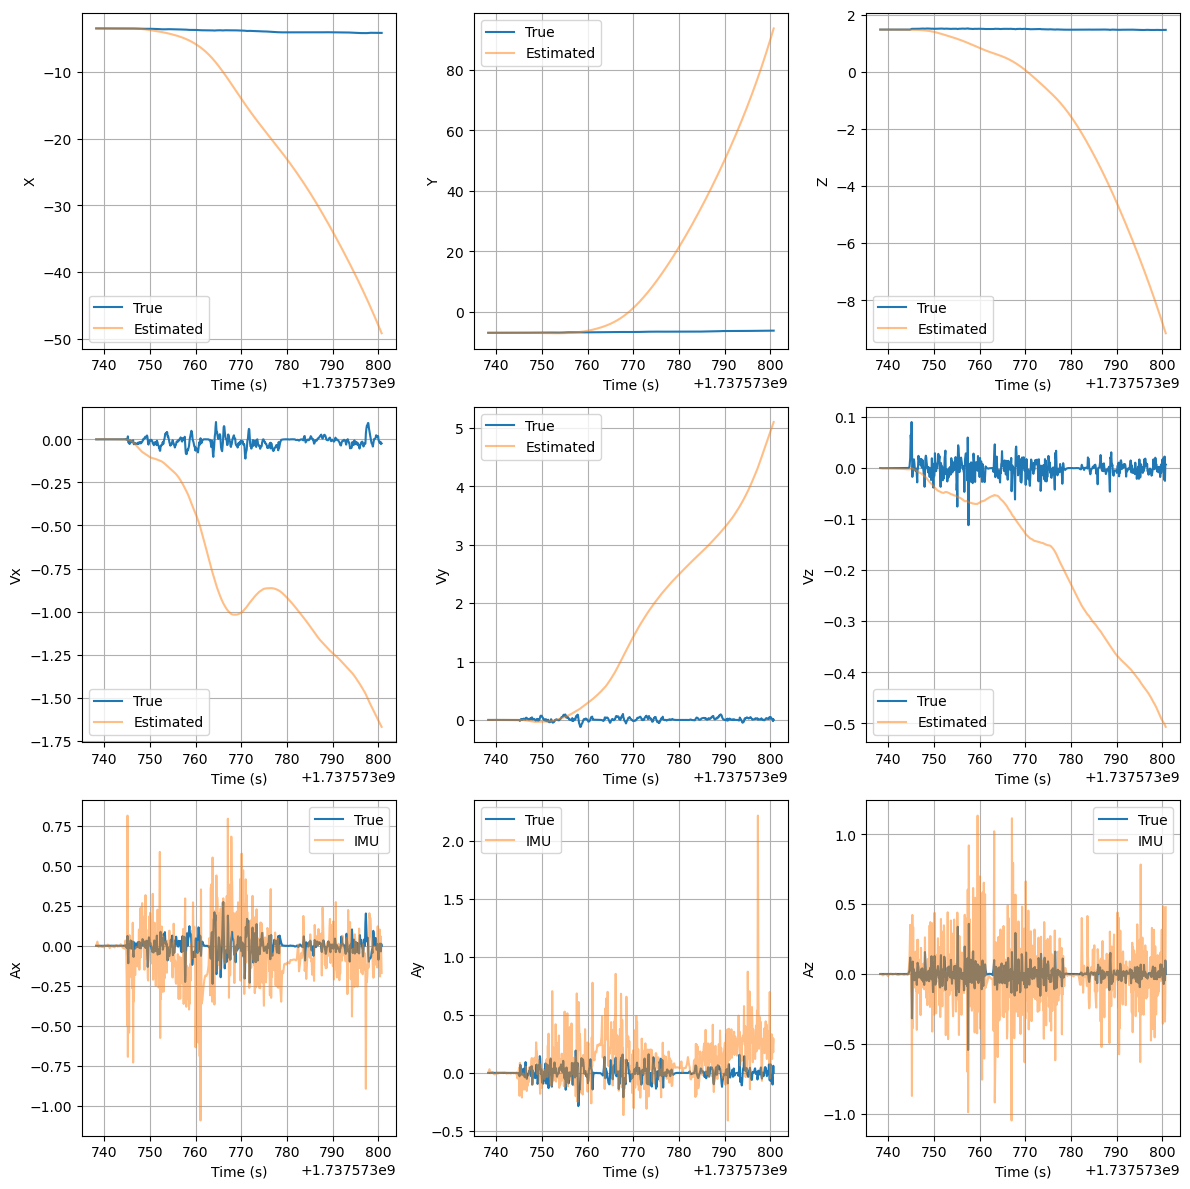

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
pos_labels = ["X", "Y", "Z", "Vx", "Vy", "Vz", "Ax", "Ay", "Az"]
plot_idx = range(10)

for i in range(9):
    ax = axes.flatten()[i]
    ax.plot(true_time[plot_idx], true_pva[plot_idx, i], label="True")
    if i < 6:
        ax.plot(true_time[plot_idx], est_posvel[plot_idx, i], label="Estimated", alpha=0.5)
    else:
        ax.plot(true_time[plot_idx], imu_acc_meass[plot_idx, i-6], label="IMU", alpha=0.5)
        # ax.set_ylim(-0.01, 0.01)
    ax.legend()
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(f"{pos_labels[i]}")

plt.tight_layout()
plt.show()


## Plot Recorded Attitude

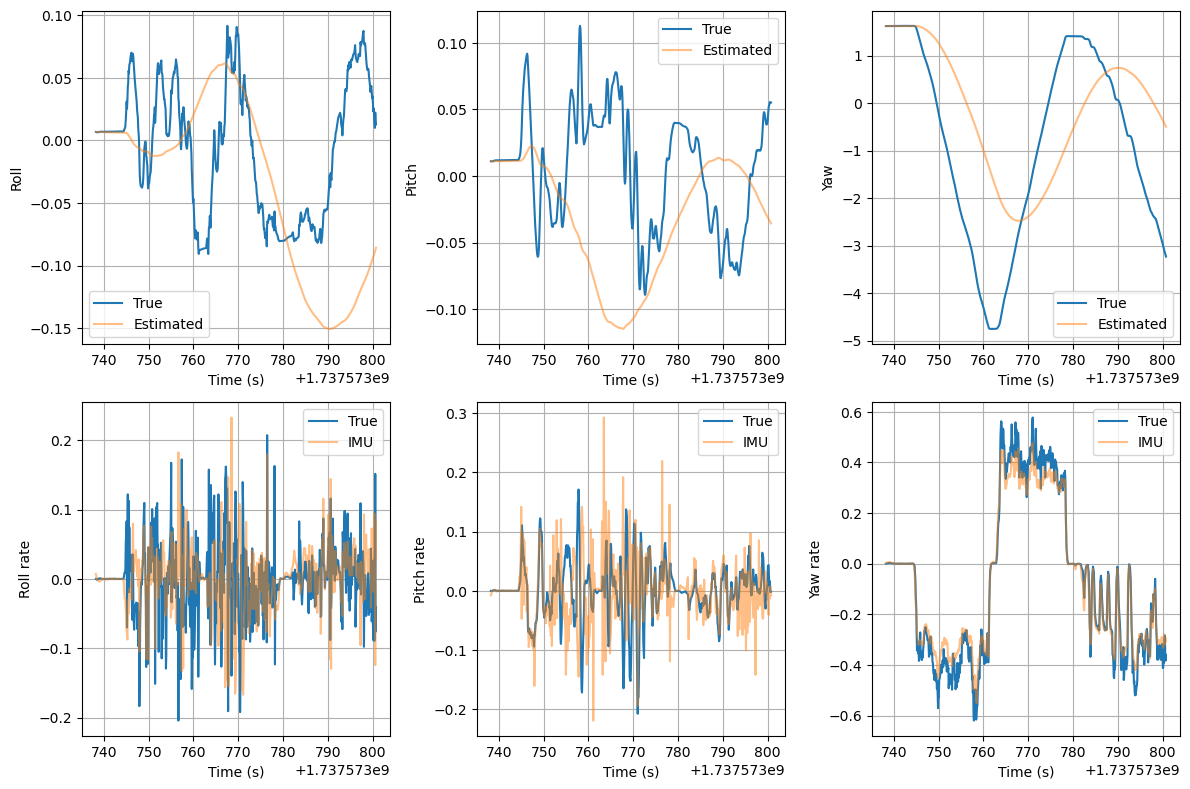

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
pos_labels = ["Roll", "Pitch", "Yaw", "Roll rate", "Pitch rate", "Yaw rate"]
for i in range(6):
    ax = axes.flatten()[i]
    ax.plot(true_time, true_att[:, i], label="True")
    if i < 3:
        ax.plot(true_time, est_att[:, i], label="Estimated", alpha=0.5)
    else:
        ax.plot(true_time, imu_gyro[:, i-3], label="IMU", alpha=0.5)
    ax.legend()
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(f"{pos_labels[i]}")

plt.tight_layout()
plt.show()